In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
df = pd.read_csv('Predictions_filtered.tsv', delimiter='\t')
df['family'] = df['family'].str[7:-6]
df['V1'] = df['V1'].str[3:]
df.rename(columns={'V1':'chr'}, inplace=True)
df_grouped = df.groupby(['chr','family']).size().reset_index(name='count')
df_grouped = df_grouped.sort_values(['chr', 'family'], ascending=[True, True])
df_grouped.head()

,chr,family,count
0,1,1,87
1,1,10,45
2,1,11,29
3,1,12,73
4,1,13,57


In [145]:
dfs = []

#conditions = ['siControl', 'siControl_H3K4me3', 'siBRD4', 'siBAZ2A', 'siBAZ2B']
conditions = ['siControl', 'siBAZ2A', 'siBAZ2B']
path = '../cut&tag-cluster-results/'
for condition in conditions:
    df = pd.read_csv(path + f'{condition}_HQ_raw_MACS2_predicted_families.tsv', delimiter='\t')[['family']]
    df['family'] = df['family'].str[7:-6].astype(int)
    df['condition'] = condition
    dfs.append(df)
    
df_families = pd.concat(dfs, ignore_index=True)
df_grouped = df_families.groupby(['condition','family']).size().reset_index(name='count')

all_combos = pd.MultiIndex.from_product([conditions, range(1, 96)], names=['condition', 'family']).to_frame(index=False)

df_grouped = all_combos.merge(df_grouped, on=['condition', 'family'], how='left').fillna(0)

totals = df_grouped.groupby('condition')['count'].sum().reset_index(name='total')
df_grouped = df_grouped.merge(totals, on='condition')

df_grouped['proportion'] = df_grouped['count']/df_grouped['total']
df_grouped

,condition,family,count,total,proportion
0,siControl,1,5.0,1126.0,0.004440
1,siControl,2,1.0,1126.0,0.000888
2,siControl,3,5.0,1126.0,0.004440
3,siControl,4,0.0,1126.0,0.000000
4,siControl,5,6.0,1126.0,0.005329
...,...,...,...,...,...
280,siBAZ2B,91,5.0,1578.0,0.003169
281,siBAZ2B,92,11.0,1578.0,0.006971
282,siBAZ2B,93,6.0,1578.0,0.003802
283,siBAZ2B,94,8.0,1578.0,0.005070


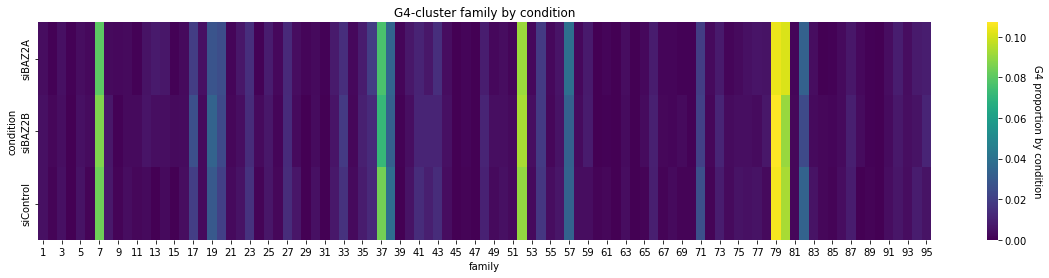

In [148]:
pivoted_df = df_grouped.pivot(index='condition', columns='family', values='proportion')
plt.figure(figsize=(20, 4))
plt.title('G4-cluster family by condition')
heatmap = sns.heatmap(pivoted_df, vmin=0, vmax=pivoted_df.max().max(), cmap='viridis')

colorbar = heatmap.collections[0].colorbar
colorbar.set_label('G4 proportion by condition', rotation=270, labelpad=15)

plt.savefig('heatmap_version2.jpg')

In [133]:
import altair as alt

In [143]:
chart = alt.Chart(df_grouped).mark_rect().encode(
    x=alt.X('family:O', title='Family'),
    y=alt.Y('condition:O', title='Condition'),
    color=alt.Color('proportion:Q', scale=alt.Scale(scheme='viridis'), title='Proportion'),
    tooltip=['condition', 'family', 'count', 'proportion']
).properties(
    title='G4-Cluster Family by Condition',
    width=1000,
    height=200
)

chart.save('interactive_heatmap.html')